# **NLP Standard Project**
## **Emotion Discovery and Reasoning its Flip in Conversation (EDiReF) - SemEval 2024 – Task 10 - Task C – EFR in English conversation:**
### Given a multiparty code-mixed conversation along with emotions for each utterance, the goal is to identify the trigger utterance for each emotionflip in the dialogue

In [1]:
# Some useful imports
import pandas as pd
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For modeling
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
import itertools

# For BERT-baesd models
import torch
import transformers
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from torch import cuda

# For metrics
from sklearn.metrics import classification_report, f1_score, confusion_matrix

In [2]:
# Set the device
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


# *DATA LOADING*

### Loading the JSON into a Pandas Dataframe and taking a first look to its structure:

In [4]:
# Load the JSON file and read it into a DataFrame
#file_path_train = '/kaggle/input/dataset/MELD_train_efr.json'
file_path_train = '/kaggle/input/meld-train-efr/MELD_train_efr.json'
#file_path_train = './Data/Task C/MELD_train_efr.json'
df = pd.read_json(file_path_train)

# Store a copy of the original DataFrame
original_df = df.copy()

df.shape

(4000, 5)

In [5]:
# Take a look to data structure
df.head()

,episode,speakers,emotions,utterances,triggers
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


# *PRE-PROCESSING*

## NaN values:
### Some trigger labels are not correctly formatted and appear as NaN values, so we convert them to 0 values to avoid errors.

In [10]:
# Count the number of NaN values
count = sum(elem != 1 and elem != 0 for row in df["triggers"] for elem in row)
print(f"Number of NaN values: {count}")

Number of NaN values: 0


In [11]:
# Convert NaN values to 0
df["triggers"] = df["triggers"].apply(lambda x: [0 if elem != 1 and elem != 0 else elem for elem in x])

In [12]:
# Verify that all NaN values have been converted
count = sum(elem != 1 and elem != 0 for row in df["triggers"] for elem in row)
print(f"Number of NaN values: {count}")

Number of NaN values: 0


## Splitting of data
### We use a 80/10/10 train/val/test split, as explicitly required by the prooject description:

In [13]:
# Split the DataFrame into training, validtion and test set
df_train, temp = train_test_split(df, test_size=0.2, shuffle=False)
df_test, df_val = train_test_split(temp, test_size=0.5, shuffle=False)

# Print the shape of each set
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (3200, 5)
Test shape: (400, 5)
Val shape: (400, 5)


### We observe the fact that a common dialogue is present both at at the end of training set and at the beginning of validation set. We decide to slightly refine the sizes of data, in such a way to keep the dialogue only in one of the two sets:

In [14]:
print(f"Dialogue in the last row of df_train: {df_train['utterances'][3199]}")

Dialogue in the last row of df_train: ["Dr. Geller, there's a seat over here.", "Thank you, Dr. Phillips, but I'm having my lunch at this table, here in the middle.", "I'm having lunch right here, with my good friend Joey, if he'll sit with me.", 'I will sit with you Dr. Geller.', "Y'know, we work in a museum of natural history, and yet there is something unnatural about the way we eat lunch.", "Now, I look around this cafeteria, and y'know what I see, I see-I see division.", 'Division, between people in white coats and people in blue blazers, and I ask myself, "My God why?!"', 'Now, I say we shed these-these coats that separate us, and we get to know the people underneath.']


In [130]:
print(f"Dialogue in the first row of df_test: {df_test['utterances'][3200]}")

Dialogue in the first row of df_test: ["Dr. Geller, there's a seat over here.", "Thank you, Dr. Phillips, but I'm having my lunch at this table, here in the middle.", "I'm having lunch right here, with my good friend Joey, if he'll sit with me.", 'I will sit with you Dr. Geller.', "Y'know, we work in a museum of natural history, and yet there is something unnatural about the way we eat lunch.", "Now, I look around this cafeteria, and y'know what I see, I see-I see division.", 'Division, between people in white coats and people in blue blazers, and I ask myself, "My God why?!"', 'Now, I say we shed these-these coats that separate us, and we get to know the people underneath.', "I'm Ross!"]


In [131]:
print(f"The dialogue continues until utterance 3205:")
print(f"Dialogue: {df_test['utterances'][3205]}")

The dialogue continues until utterance 3205:
Dialogue: ["Dr. Geller, there's a seat over here.", "Thank you, Dr. Phillips, but I'm having my lunch at this table, here in the middle.", "I'm having lunch right here, with my good friend Joey, if he'll sit with me.", 'I will sit with you Dr. Geller.', "Y'know, we work in a museum of natural history, and yet there is something unnatural about the way we eat lunch.", "Now, I look around this cafeteria, and y'know what I see, I see-I see division.", 'Division, between people in white coats and people in blue blazers, and I ask myself, "My God why?!"', 'Now, I say we shed these-these coats that separate us, and we get to know the people underneath.', "I'm Ross!", "I'm divorced, and I have a kid!", "I'm Joey! I'm an actor! I don't know squat about dinosaurs!", "I'm Ted, and I just moved here a month ago, and New York really scares me.", 'All right, there you go!', 'Yeah, you hang in there Teddy!', "I'm Andrew, and I didn't pay for this pear.", 

In [132]:
print(f"Dialogue in the last row of df_test: {df_test['utterances'][3599]}")

Dialogue in the last row of df_test: ['Oh, that is so unfortunate.', 'What?', 'Cute naked guy is really starting to put on weight.', "Okay, I'll be back in just a minute. Oh, Phoebe I'm sorry that I left lipstick marks on the phone.", "You didn't leave lipstick marks on the phone.", "Oh, then it must've been you. Bye.", "Bye-bye!  That's why I moved out.", "Hey, y'know while we're on that, when are you gonna tell my sister that you don't live here anymore.", 'I think on some levels she already knows.']


In [133]:
print(f"Dialogue in the first row of df_val: {df_val['utterances'][3600]}")

Dialogue in the first row of df_val: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?']


In [15]:
# Reshape the sets to take into account this observation
df_train = df.iloc[:3205,:]
temp = df.iloc[3205:,:]

df_test, df_val = train_test_split(temp, test_size=0.5, shuffle=False)

# Print the new shape of the three sets
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (3205, 5)
Test shape: (397, 5)
Val shape: (398, 5)


### We make a similar observation printing the last utterance of validation set and the first one of test set:

In [135]:
print(f"Dialouge in the last row of df_test: {df_test['utterances'][3601]}")

Dialouge in the last row of df_test: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?', 'Flowers of Evil, by Beaudalire. Have you read it?', 'Have I read it?  No, are you enjoying it?', "I thought I would, but the translation's no good.", "Your a poet and don't know it.", 'Actually I ah, I am a poet.', 'Oh, then you do know it.  So um what kind of things do you write about?', 'Things that move me. The, the shadow of a tree, a child laughing, or this lip.', 'Mine?  Right here?', 'I can write an epic poem about this lip.']


In [136]:
print(f"Dialouge in the first row of df_val: {df_val['utterances'][3602]}")

Dialouge in the first row of df_val: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?', 'Flowers of Evil, by Beaudalire. Have you read it?', 'Have I read it?  No, are you enjoying it?', "I thought I would, but the translation's no good.", "Your a poet and don't know it.", 'Actually I ah, I am a poet.', 'Oh, then you do know it.  So um what kind of things do you write about?', 'Things that move me. The, the shadow of a tree, a child laughing, or this lip.', 'Mine?  Right here?', 'I can write an epic poem about this lip.', "How would that go?  Well, it didn't rhyme, but I liked it."]


In [16]:
# Reshape the sets in a similar way as before
df_train = df.iloc[:3205,:]
df_test = df.iloc[3205:3603,:]
df_val = df.iloc[3603:,:]

In [138]:
print(f"Dialouge in the last row of df_test: {df_test['utterances'][3602]}")

Dialouge in the last row of df_test: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?', 'Flowers of Evil, by Beaudalire. Have you read it?', 'Have I read it?  No, are you enjoying it?', "I thought I would, but the translation's no good.", "Your a poet and don't know it.", 'Actually I ah, I am a poet.', 'Oh, then you do know it.  So um what kind of things do you write about?', 'Things that move me. The, the shadow of a tree, a child laughing, or this lip.', 'Mine?  Right here?', 'I can write an epic poem about this lip.', "How would that go?  Well, it didn't rhyme, but I liked it."]


In [139]:
print(f"Dialouge in the first row of df_val: {df_val['utterances'][3603]}")

Dialouge in the first row of df_val: ['Last stop, Montreal. This stop is Montreal.', 'What?', 'I made a bet with myself that you have beautiful eyes. Now that I see them, I win.', 'What?', "We're at my stop. But would you like to have coffee?", 'Are we really in Montreal?!', 'Yes we are. So, coffee?', 'Coffee sounds great.  Wait, so, so you live in Montreal?']


### The final shape of data is the following:

In [17]:
# Print the final shape of the sets
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (3205, 5)
Test shape: (398, 5)
Val shape: (397, 5)


## Splitting of every sentence in the DataFrames' dialogues

In [18]:
# Define the splitting function
def split_utterances(df):
    # Initiate some useful lists before iteration
    speakers_list = []
    utterances_list = []
    emotions_list = []
    trigger_list = []

    # Iterate over each row of the original DataFrame
    for index, row in df.iterrows():
        speakers = row['speakers']
        utterances = row['utterances']
        emotions = row['emotions']
        triggers = row['triggers']

        # Iterate over each utterance in 'utterances' array
        for i in range(len(utterances)):
            speakers_list.append(speakers[i])
            utterances_list.append(utterances[i])
            emotions_list.append(emotions[i])
            trigger_list.append(triggers[i])

    # Convert the lists into a new DataFrame
    new_df = pd.DataFrame({
        'speaker': speakers_list,
        'utterance': utterances_list,
        'emotion': emotions_list,
        'trigger': trigger_list
    })

    return new_df

In [20]:
# Split into sentences the training set
df_train_s = split_utterances(df_train)
df_train_s.head(15)

,speaker,utterance,emotion,trigger
0,Chandler,also I was the point person on my company's tr...,neutral,0.0
1,The Interviewer,You must've had your hands full.,neutral,0.0
2,Chandler,That I did. That I did.,neutral,0.0
3,The Interviewer,So let's talk a little bit about your duties.,neutral,1.0
4,Chandler,My duties? All right.,surprise,0.0
5,Chandler,also I was the point person on my company's tr...,neutral,0.0
6,The Interviewer,You must've had your hands full.,neutral,0.0
7,Chandler,That I did. That I did.,neutral,0.0
8,The Interviewer,So let's talk a little bit about your duties.,neutral,0.0
9,Chandler,My duties? All right.,surprise,0.0


In [21]:
# Take a look to the new structure of the training set
print(df_train_s.iloc[52:69,:])

     speaker                                          utterance   emotion  \
52  Chandler                                          Hey, Mon.   neutral   
53    Monica  Hey-hey-hey. You wanna hear something that sucks.   neutral   
54  Chandler                                         Do I ever.       joy   
55  Chandler                                          Hey, Mon.   neutral   
56    Monica  Hey-hey-hey. You wanna hear something that sucks.   neutral   
57  Chandler                                         Do I ever.       joy   
58    Monica           Chris says they're closing down the bar.   sadness   
59  Chandler                                          Hey, Mon.   neutral   
60    Monica  Hey-hey-hey. You wanna hear something that sucks.   neutral   
61  Chandler                                         Do I ever.       joy   
62    Monica           Chris says they're closing down the bar.   sadness   
63  Chandler                                            No way!  surprise   

In [22]:
# Split into sentences of the remaining sets
df_test_s = split_utterances(df_test)

df_val_s = split_utterances(df_val)

## *DATA EXPLORATION*
### Is the train dataset imbalanced? We verify this hypothesis both for 'emotions' and 'triggers' labels:

### Emotions distribution:

In [23]:
# Count the distribution of 'emotions' values in the DataFrame
emotions_counts = {}
for emotions in df_train['emotions']:
    for emotion in emotions:
        if emotion in emotions_counts:
            emotions_counts[emotion] += 1
        else:
            emotions_counts[emotion] = 1

# Print the counts
print(emotions_counts)

{'neutral': 12264, 'surprise': 3777, 'fear': 922, 'sadness': 1934, 'joy': 5141, 'disgust': 816, 'anger': 3031}


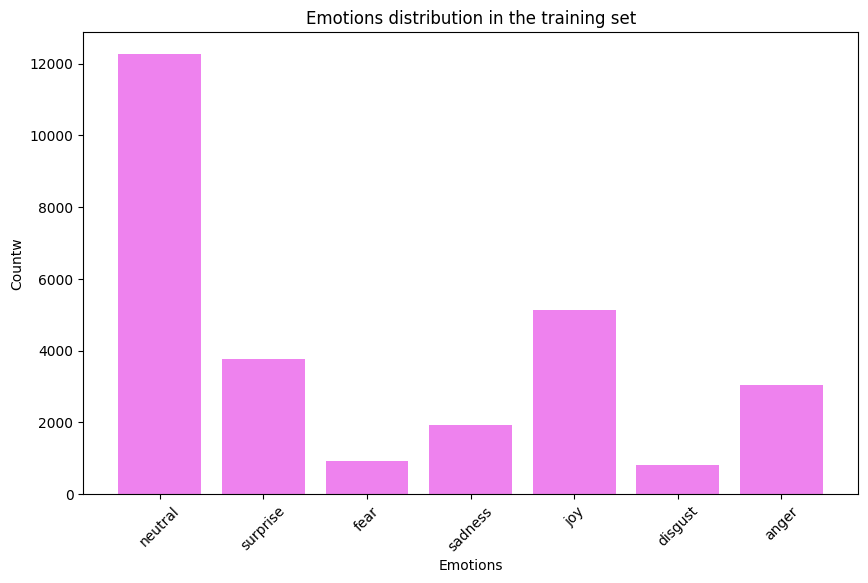

In [17]:
# Convert the dictionary of counts into two lists
emotions = list(emotions_counts.keys())
emotion_counts = list(emotions_counts.values())

# Plotting a histogram for such counts
plt.figure(figsize=(10, 6))
plt.bar(emotions, emotion_counts, color='violet')
plt.xlabel('Emotions')
plt.ylabel('Countw')
plt.title('Emotions distribution in the training set')
plt.xticks(rotation=45)
plt.show()

### Triggers distribution:

In [24]:
# Count the distribution of 'triggers' values
triggers_counts= {}
for triggers in df_train['triggers']:
    for trigger in triggers:
        if trigger in triggers_counts:
            triggers_counts[trigger] += 1
        else:
            triggers_counts[trigger] = 1
            
# Print such counts
print(triggers_counts)

{0.0: 23586, 1.0: 4299}


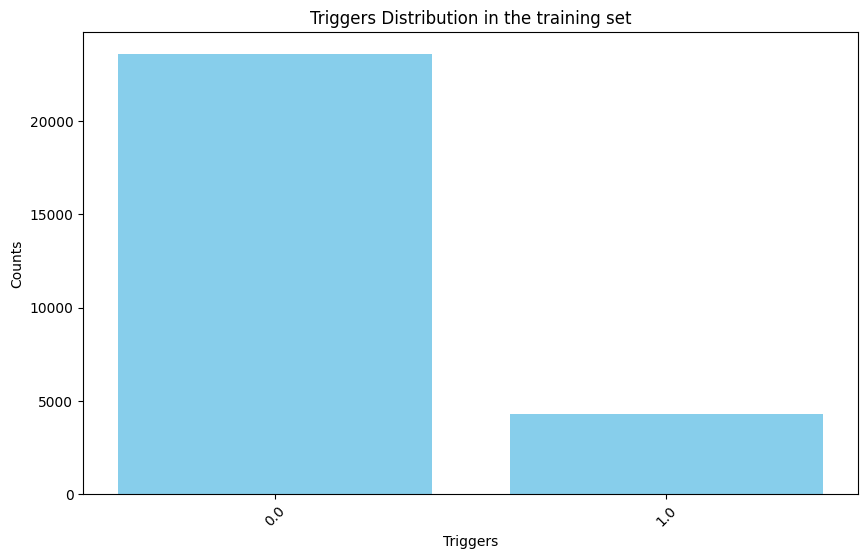

In [25]:
# Convert the dictionary of counts into two lists
trigger = list(triggers_counts.keys())
trigger_counts = list(triggers_counts.values())

# Plot a histogram for such counts
plt.figure(figsize=(10, 6))
plt.bar(trigger, trigger_counts, color='skyblue')
plt.xlabel('Triggers')
plt.ylabel('Counts')
plt.title('Triggers Distribution in the training set')
plt.xticks(ticks=trigger, labels=['0.0', '1.0'], rotation=45)
plt.show()

In [26]:
# Calculate classes' weights
total_samples = len(df_train)
class_weights = {emotion: total_samples / (len(emotions_counts) * count) for emotion, count in emotions_counts.items()}

# Print such weights
print("Class weights:", class_weights)

Class weights: {'neutral': 0.03733342652129345, 'surprise': 0.12122243655206325, 'fear': 0.4965912612333437, 'sadness': 0.23674102526222485, 'joy': 0.08905993831105677, 'disgust': 0.5610994397759104, 'anger': 0.1510581137766885}


### As we can see both emotions and triggers are highly imbalanced, the emotion with the highest count is 'neutral' and the trigger with the highest count is '0.0'.

### When a class imbalance exists within the training data, machine learning models will typically over-classify the larger classes due to their increased prior probability. As a result, the instances belonging to the smaller class(es) are typically misclassified more often than those belonging to the larger class(es).
### How to deal with imbalanced data in classification? https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data

### We choose Class Weighting for dealing with this imbalance:

In [27]:
all_emotions = [label for sublist in df_train['emotions'] for label in sublist]
train_emotions = np.array(all_emotions)
unique_emotions = np.unique(all_emotions)

# Calculate weights
emotion_weights = class_weight.compute_class_weight(class_weight='balanced', classes=unique_emotions, y=train_emotions)

# Save the weights in a dictionary 
emotions_weights_dict = dict(zip(unique_emotions, emotion_weights))

print("Emotion class weights:", emotions_weights_dict)

Emotion class weights: {'anger': 1.3142762878823584, 'disgust': 4.881827731092437, 'fear': 4.320576386736907, 'joy': 0.7748631450245922, 'neutral': 0.3248182834777747, 'sadness': 2.059757719013148, 'surprise': 1.0546919323726314}


### Class weights computing using sklearn class_weight='balanced'

In [28]:
# Calculate triggers' weights
all_triggers = [label for sublist in df_train['triggers'] for label in sublist]
train_triggers = np.array(all_triggers)
unique_triggers = np.unique(all_triggers)

trigger_weights = class_weight.compute_class_weight(class_weight='balanced', classes=unique_triggers, y=train_triggers)
triggers_weights_dict = dict(zip(unique_triggers, trigger_weights))

print("Trigger class weights:", triggers_weights_dict)

Trigger class weights: {0.0: 0.5911345713558891, 1.0: 3.243196092114445}


## *MODELS DEFINITION*

### As explicitly requested, we should train and evaluate a BERT baseline on two different settings:
####    1. Freezed: we freeze the BERT embedding layer weights and fine-tune the classifier heads on top
####    2. Full: we fine-tune the whole model architecture.
     
### In addition, we should evaluate a random and a majority classifier for emotions and triggers.

### Baseline models
#### Defining random and majority dummy classifiers

In [30]:
# Defining classifiers for emotions
random_emotions = DummyClassifier(strategy='uniform', random_state = 42)
majority_emotions = DummyClassifier(strategy='most_frequent')
# Defining classifiers for triggers
random_triggers = DummyClassifier(strategy='uniform', random_state = 42)
majority_triggers = DummyClassifier(strategy='most_frequent')

In [31]:
# Look again at the structure of the DataFrame
df_train_s.head()

,speaker,utterance,emotion,trigger
0,Chandler,also I was the point person on my company's tr...,neutral,0.0
1,The Interviewer,You must've had your hands full.,neutral,0.0
2,Chandler,That I did. That I did.,neutral,0.0
3,The Interviewer,So let's talk a little bit about your duties.,neutral,1.0
4,Chandler,My duties? All right.,surprise,0.0


In [32]:
# Isolate labels for training set
X_train = df_train_s.drop(columns=['emotion', 'trigger'])

y_train_emotions = df_train_s['emotion']
y_train_triggers = df_train_s['trigger']

In [33]:
# Isolate labels for test set
X_test = df_test_s.drop(columns=['emotion', 'trigger'])

y_test_emotions = df_test_s['emotion']
y_test_triggers = df_test_s['trigger']

In [34]:
# Fit the emotions' dummy classifiers
random_emotions.fit(X_train, y_train_emotions)
majority_emotions.fit(X_train, y_train_emotions)

# Fit the triggers' dummy classifiers
random_triggers.fit(X_train, y_train_triggers)
majority_triggers.fit(X_train, y_train_triggers)

DummyClassifier(strategy='most_frequent')

#### Evaluating baseline models

In [35]:
# Evaluate emotions' dummy classifiers on test set
y_pred_random_emotions = random_emotions.predict(X_test)
y_pred_majority_emotions = majority_emotions.predict(X_test)

# Evaluate triggers' dummy classifiers on test set
y_pred_random_triggers = random_triggers.predict(X_test)
y_pred_majority_triggers = majority_triggers.predict(X_test)

In [36]:
# Print classification reports

# For emotions
print("Classification report for baseline random clf emotions:")
print(classification_report(y_test_emotions, y_pred_random_emotions, zero_division=0))

print("Classification report for baseline majority clf emotions:")
print(classification_report(y_test_emotions, y_pred_majority_emotions, zero_division=0))

# For triggers
print("Classification report for baseline random clf triggers:")
print(classification_report(y_test_triggers, y_pred_random_triggers, zero_division=0))

print("Classification report for baseline majority clf triggers:")
print(classification_report(y_test_triggers, y_pred_majority_triggers, zero_division=0))

Classification report for baseline random clf emotions:
              precision    recall  f1-score   support

       anger       0.15      0.16      0.15       455
     disgust       0.03      0.17      0.05        88
        fear       0.03      0.12      0.05       121
         joy       0.16      0.14      0.15       576
     neutral       0.39      0.13      0.20      1505
     sadness       0.10      0.14      0.11       349
    surprise       0.12      0.14      0.13       439

    accuracy                           0.14      3533
   macro avg       0.14      0.14      0.12      3533
weighted avg       0.24      0.14      0.16      3533

Classification report for baseline majority clf emotions:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       455
     disgust       0.00      0.00      0.00        88
        fear       0.00      0.00      0.00       121
         joy       0.00      0.00      0.00       576
     neutral      

### BERT-based models

#### One-Hot-Encoding

In [37]:
# Define an encoding dictionary for emotions label
emotions_encoded_dict = {
    "neutral": [1, 0, 0, 0, 0, 0, 0],
    "joy": [0, 1, 0, 0, 0, 0, 0],
    "surprise": [0, 0, 1, 0, 0, 0, 0],
    "sadness": [0, 0, 0, 1, 0, 0, 0],
    "anger": [0, 0, 0, 0, 1, 0, 0],
    "disgust": [0, 0, 0, 0, 0, 1, 0],
    "fear": [0, 0, 0, 0, 0, 0, 1]
}

In [38]:
# Define an encoding dictionary for triggers label
triggers_encoded_dict = {
    0: [1, 0],
    1: [0, 1]
}

#### Data exploration: we want to correctly define the max_length parameter for tokenization

   word_length
0           16
1           16
2           17
3           26
4           11


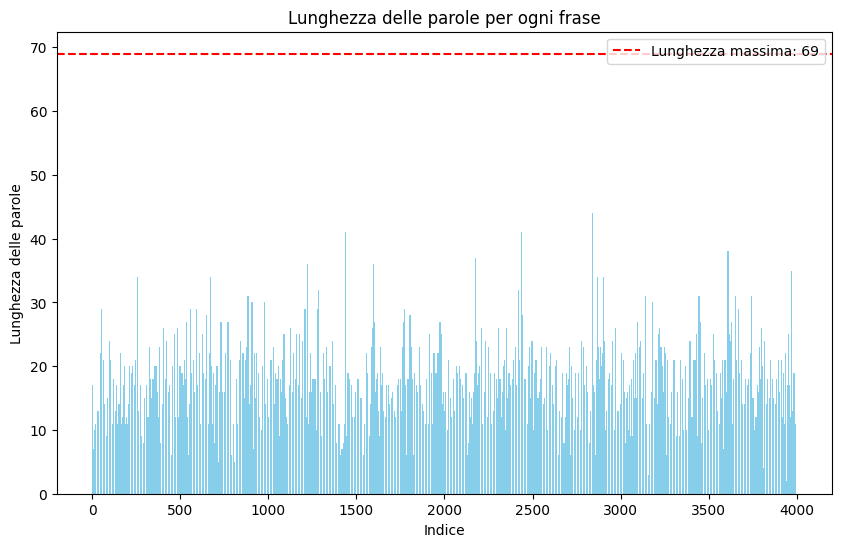

In [39]:
# Calculate the length of every word for every row in 'utterances'
df_length = pd.DataFrame()
df_length['word_length'] = df['utterances'].apply(lambda arr: max(len(x.split()) for x in arr))

print(df_length.head())

# Calculate the maximum length over all rows
max_length = df_length['word_length'].max()


# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.bar(df_length.index, df_length['word_length'], color='skyblue')
plt.axhline(y=max_length, color='r', linestyle='--', label=f'Lunghezza massima: {max_length}')
plt.xlabel('Indice')
plt.ylabel('Lunghezza delle parole')
plt.title('Lunghezza delle parole per ogni frase')
plt.legend()
plt.show()

#### We can see that the maximum number of words in a dialogue is 263, so if we consider it as the MAX_LENGTH value for the padding process we would cover all the utterances.

max length: 263
max length id: 3901


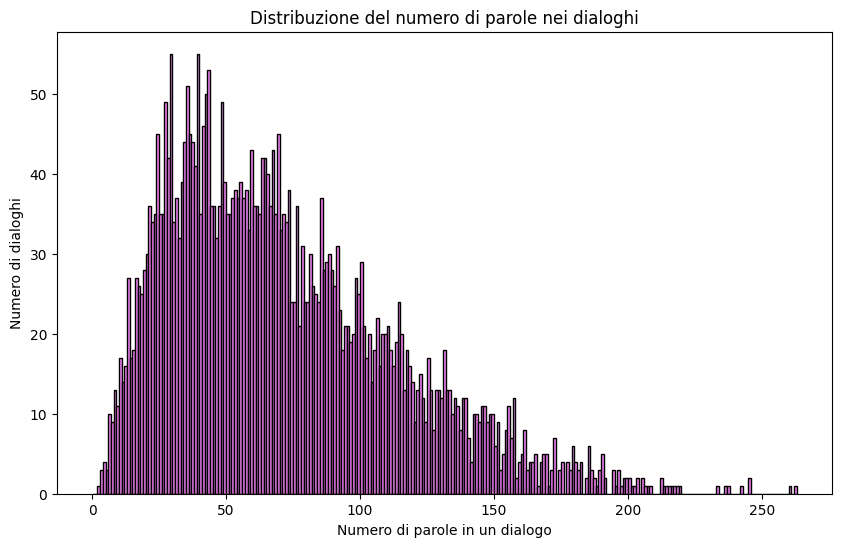

In [42]:
# Calculate the length of each word for every row in 'utterances' column
df_length = pd.DataFrame()
df_length['total_word_length'] = df['utterances'].apply(lambda arr: sum(len(x.split()) for x in arr))

# Calculate the maximum length over all the rows
max_length = df_length['total_word_length'].max()
print(f"max length: {max_length}")

# Get the id of the longest dialogue
max_length_id = df_length['total_word_length'].idxmax()
print(f"max length id: {max_length_id}")


# Plot a histogram
plt.figure(figsize=(10, 6))
plt.hist(df_length['total_word_length'], bins=range(0, df_length['total_word_length'].max() + 1, 1), color='violet', edgecolor='black')
plt.xlabel('Numero di parole in un dialogo')
plt.ylabel('Numero di dialoghi')
plt.title('Distribuzione del numero di parole nei dialoghi')
plt.show()

#### We also show also the boxplot of the distribution to check for outliers values: as we expected, there are only fews dialogues that exceed 256. For this reason we use the nearest squared value which is 256 and not 512.

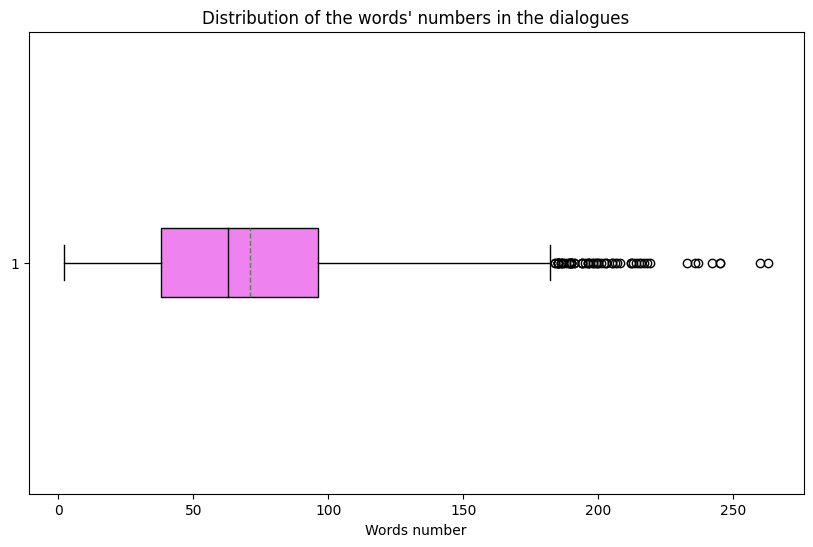

In [43]:
# Box-plot
plt.figure(figsize=(10, 6))
plt.boxplot(df_length['total_word_length'], vert=False, patch_artist=True, boxprops=dict(facecolor='violet'), 
            medianprops=dict(color='black'), meanline=True, showmeans=True)
plt.xlabel("Words number")
plt.title("Distribution of the words' numbers in the dialogues")
plt.show()

### Tokenization step

In [ ]:
# Definition of tokenizer and useful hyperprameters
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 256
BATCH_SIZE = 32 

### Dataset definition, as expected by BERT-based classifiers

In [45]:
# Define the Class for the tokenized Dataset for BERT
class BERTDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.emotions_encoded_dict = emotions_encoded_dict
        self.triggers_encoded_dict = triggers_encoded_dict
        self.data = self._create_data()
    
    # Split the Data into single sentences
    def _create_data(self):
        data = []
        for _, row in self.dataframe.iterrows():
            episode = row['episode']
            utterances = row["utterances"]
            emotions = row["emotions"]
            triggers = row["triggers"]
            for utterance, emotion, trigger in zip(utterances, emotions, triggers):
                data.append((episode, utterance, emotion, trigger))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        episode, utterance, emotion, trigger = self.data[index]
        target_emotion = self.emotions_encoded_dict[emotion]
        target_trigger = self.triggers_encoded_dict[trigger]

        encoding = self.tokenizer.encode_plus(
            utterance,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding="max_length",
            truncation=True,
        )

        input_ids = encoding["input_ids"]
        attention_mask = encoding["attention_mask"]
        token_type_ids = encoding["token_type_ids"]
        
        return {
            "episode": episode,
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "target_emotion": torch.tensor(target_emotion, dtype=torch.float),
            "target_trigger": torch.tensor(target_trigger, dtype=torch.float),
        }

In [46]:
# Create Datasets from training, validation and test DataFrames
bert_train_dataset = BERTDataset(df_train, tokenizer, MAX_LENGTH)
bert_test_dataset = BERTDataset(df_val, tokenizer, MAX_LENGTH)
bert_val_dataset = BERTDataset(df_val, tokenizer, MAX_LENGTH)

# Data-loading step
train_loader= DataLoader(bert_train_dataset, batch_size=BATCH_SIZE, shuffle=True) #ricontrollare se shuffle deve essere true o false
test_loader = DataLoader(bert_test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(bert_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [48]:
# Take a look at the structure of a tokenized row
print(train_loader.dataset[0])

{'episode': 'utterance_0', 'input_ids': tensor([  101,  2036,  1045,  2001,  1996,  2391,  2711,  2006,  2026,  2194,
         1005,  1055,  6653,  2013,  1996,  1047,  2140,  1011,  1019,  2000,
        24665,  1011,  1020,  2291,  1012,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,   

In [50]:
# Print the keys in the DataLoader object
print(train_loader)
print('\n')

for batch in train_loader:
    print(batch.keys())
    break  # only prints the keys for the first batch, as the others have a similar structure



dict_keys(['episode', 'input_ids', 'attention_mask', 'token_type_ids', 'target_emotion', 'target_trigger'])


### BERT model definition

#### Our source was https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForPreTraining


In [51]:
# Definition of BERT model Class
class BERTClass(torch.nn.Module):
    def __init__(self,model):
        super(BERTClass, self).__init__()
        self.l1 = transformers.AutoModel.from_pretrained(model, return_dict=False)
        # Emotions
        self.l2 = torch.nn.Dropout(p=0.3)
        self.l3 = torch.nn.Linear(self.l1.config.hidden_size, 7)
        # Triggers
        self.l4 = torch.nn.Dropout(p=0.3)
        self.l5 = torch.nn.Linear(self.l1.config.hidden_size, 2)

    def forward(self, ids, mask, token_type_ids, episode):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_emotions = self.l2(output_1)
        output_emotions = self.l3(output_emotions)
        output_trigger = self.l4(output_1)
        output_trigger = self.l5(output_trigger)
        return episode, output_emotions, output_trigger

In [ ]:
# Use bert-base-uncased pre-trained model
model_name = 'bert-base-uncased'

# Define full model
full_model = BERTClass(model_name)
full_model.to(device)

# Define freezed model
freezed_model = BERTClass(model_name)
freezed_model.to(device)
# Freezing of parameters for freezed model
for param in freezed_model.l1.parameters():
    param.requires_grad = False

### Loss function
#### 2 weighted binary cross entropy losses, whose sum is the final output of the function

In [53]:
# Convert weights into tensors
emotions_weights_tensor = torch.tensor(list(emotions_weights_dict.values()), dtype=torch.float32).to(device)
triggers_weights_tensor = torch.tensor(list(triggers_weights_dict.values()), dtype=torch.float32).to(device)

def weighted_binary_cross_entropy_loss(emotion_output, true_emotions, trigger_output, true_triggers, emotions_weights_tensor, triggers_weights_tensor):
    # Move tensors to device
    emotions_weights_tensor = emotions_weights_tensor.to(device)
    triggers_weights_tensor = triggers_weights_tensor.to(device)

    # Emotions loss function
    loss_emotions = torch.nn.BCEWithLogitsLoss(weight=emotions_weights_tensor)
    loss_e_value = loss_emotions(emotion_output, true_emotions)

    # Triggers loss function
    loss_triggers = torch.nn.BCEWithLogitsLoss(weight=triggers_weights_tensor)
    loss_t_value = loss_triggers(trigger_output, true_triggers)

    return loss_e_value + loss_t_value

### Validation function

#### This validation function on val dataset during training. It calculates loss -using the defined loss function- and accuracy; according to this calculation, it early stops training if negative performances on validation set are detected for a fixed number of consecutive epochs; the model is saved at any positive iteration.

In [54]:
# Define validation function
def validation(model, val_loader, emotions_weights_tensor, triggers_weights_tensor):
    model.eval()
    # Initaite variables for iteration
    val_loss = 0
    correct_emotion = 0
    correct_trigger = 0
    total_emotion = 0
    total_trigger = 0

    with torch.no_grad():
        # Iterate on each validation set batch
        for _, data in enumerate(val_loader, 0):
            # Move tokenization logits on device
            episode = data['episode']
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            target_emotion = data['target_emotion'].to(device)
            target_trigger = data['target_trigger'].to(device)
            # Generate emotions and trigger outputs
            _, emotion_output, trigger_output = model(input_ids, attention_mask, token_type_ids, episode)
            # Caluclate loss using the defined function
            val_loss += weighted_binary_cross_entropy_loss(emotion_output, target_emotion, trigger_output, target_trigger, emotions_weights_tensor, triggers_weights_tensor)

            # Compute accuracy
            predicted_emotion = torch.round(torch.sigmoid(emotion_output))
            predicted_trigger = torch.round(torch.sigmoid(trigger_output))
            correct_emotion += (predicted_emotion == target_emotion).sum().item()
            total_emotion += target_emotion.numel()  # Total number of elements in target_emotion
            correct_trigger += (predicted_trigger == target_trigger).sum().item()
            total_trigger += target_trigger.numel()  # Total number of elements in target_trigger
            
    # Calculate average loss and accuracy
    val_loss /= len(val_loader)
    accuracy_emotion = correct_emotion / total_emotion
    accuracy_trigger = correct_trigger / total_trigger

    return val_loss, accuracy_emotion, accuracy_trigger

### Function to call training and validation
#### It invokes training over a fixed number of epochs; it then calls validation function.

In [55]:
def train_model(model, train_loader, validation_loader, emotions_weights_tensor, triggers_weights_tensor, num_epochs, patience, checkpoint_path, learning_rate):
    # Initiate Adam optimizer and some useful variables for iteration
    size = len(train_loader.dataset)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_val_loss = float('inf')
    patience_counter = 0

    # Move model to GPU
    model.to(device)
    
    # Iterate over num_epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}.')
        model.train()  # Set the model in train mode
        train_loss = 0.0
        
        # Iterate over every batch in the training set
        for batch, data in enumerate(train_loader, 0):
            # Move tokenization logits to device
            episode = data['episode']
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            target_emotion = data['target_emotion'].to(device)
            target_trigger = data['target_trigger'].to(device)
            optimizer.zero_grad()

            # Generate model predictions
            _, emotion_output, trigger_output = model(input_ids, attention_mask, token_type_ids, episode)

            # Compute loss using the defined function and utilizes it for updating model weights invoking the optimizer
            loss = weighted_binary_cross_entropy_loss(emotion_output, target_emotion, trigger_output, target_trigger, emotions_weights_tensor, triggers_weights_tensor)
            loss.backward()
            optimizer.step()
            
            # Update loss counter
            train_loss += loss.item()
            
            if batch%5000==0:
              current =  batch * len(data['input_ids'])
              print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
        
        # Calculate average loss over training set
        train_loss /= len(train_loader)

        # Invoke validation function
        val_loss, val_accuracy_emotion, val_accuracy_trigger = validation(model, validation_loader, emotions_weights_tensor, triggers_weights_tensor)

        # Print the computations
        print(f'Epoch {epoch+1}/{num_epochs}, Average Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy Emotion: {val_accuracy_emotion:.4f}, Val Accuracy Trigger: {val_accuracy_trigger:.4f}')

        # Manage early stopping and model checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model saved to {checkpoint_path}')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break
        print('\n')
        
print('\n')

#### Now we move to searching for the best configuration for hyperparameters.
#### We want to find the best possible trade-off between the optimization of the performances of the two models: that's why we opt for average accuracy between the two.

#### The code used for this search is the following:

In [ ]:
# Define the hyperparameter grid

hyperparameter_grid = {
    'seeds': [42, 123, 200, 322, 506],
    'epochs': [3, 5],
    'learning_rate': [1e-5, 5e-5],
    'patience': [2, 5]
}


# Function to train and evaluate both models
def train_and_evaluate_models(full_model, freezed_model, train_loader, val_loader, max_length, seed, epochs, full_model_checkpoint_path, freezed_model_checkpoint_path, learning_rate, patience):
    
    # Set the seed for reproducibility
    torch.manual_seed(seed)
    
    # Train the full model
    train_model(full_model, train_loader, val_loader, emotions_weights_tensor, triggers_weights_tensor, epochs, patience, full_model_checkpoint_path, learning_rate)
    
    
    # Evaluate the full model
    _, accuracy_emotion_full, accuracy_trigger_full = validation(full_model, val_loader, emotions_weights_tensor, triggers_weights_tensor)
    
    # Train the freezed model
    train_model(freezed_model, train_loader, val_loader, emotions_weights_tensor, triggers_weights_tensor, epochs, patience, freezed_model_checkpoint_path, learning_rate)
    
    # Evaluate the freezed model
    _, accuracy_emotion_freezed, accuracy_trigger_freezed = validation(freezed_model, val_loader, emotions_weights_tensor, triggers_weights_tensor)
    
    # Calculate the average accuracy for both models
    average_accuracy = (accuracy_emotion_full + accuracy_trigger_full + accuracy_emotion_freezed + accuracy_trigger_freezed) / 4
    
    return average_accuracy


# Initialize variables to track the best hyperparameters
best_average_accuracy = 0
best_hyperparameters = None

# Paths to the pre-trained model checkpoints
full_model_checkpoint_path = 'full_best_model.pth'
freezed_model_checkpoint_path = 'freezed_best_model.pth'

# Iterate over all combinations of hyperparameters
for seed, epochs, learning_rate, patience in itertools.product(
        hyperparameter_grid['seeds'],
        hyperparameter_grid['epochs'],
        hyperparameter_grid['learning_rate'],
        hyperparameter_grid['patience']):
    
    # Train and evaluate both models
    average_accuracy = train_and_evaluate_models(full_model, freezed_model, train_loader, val_loader, max_length, seed, epochs, full_model_checkpoint_path, freezed_model_checkpoint_path, learning_rate, patience)
    
    # Update the best hyperparameters if the current combination is better
    if average_accuracy > best_average_accuracy:
        best_average_accuracy = average_accuracy
        best_hyperparameters = {
            'seed': seed,
            'epochs': epochs,
            'learning_rate': learning_rate,
            'patience': patience
        }

print(f'Best Average Accuracy: {best_average_accuracy}')
print(f'Best Hyperparameters: {best_hyperparameters}')

#### The best configuration found shows an average_accuracy = 0.865597830421951.

#### We now train and evaluate both models using the selected hyperparameters:

In [56]:
# Define the best configuration of hyperparameters
seed = 42
epochs = 5
learning_rate = 5e-5
patience = 2 

# Set the seed for reproducibility
torch.manual_seed(seed);

#### Training of full model

In [58]:
# Invoke training function for full model
train_model(full_model, train_loader, val_loader,  emotions_weights_tensor, triggers_weights_tensor, epochs, patience, 'full_best_model.pth', learning_rate)

print("Training completed for full model!")

Epoch 1/5.
Train loss: 3.695890  [    0/27885]
Epoch 1/5, Average Train Loss: 1.3352, Val Loss: 1.4648, Val Accuracy Emotion: 0.8873, Val Accuracy Trigger: 0.8548
Model saved to full_best_model.pth


Epoch 2/5.
Train loss: 1.012529  [    0/27885]
Epoch 2/5, Average Train Loss: 1.0354, Val Loss: 1.6255, Val Accuracy Emotion: 0.8851, Val Accuracy Trigger: 0.8548


Epoch 3/5.
Train loss: 1.199360  [    0/27885]
Epoch 3/5, Average Train Loss: 0.9269, Val Loss: 1.7620, Val Accuracy Emotion: 0.8809, Val Accuracy Trigger: 0.8505
Early stopping
Training completed for full model!


#### Training of freezed model

In [57]:
# Invoke training function for freezed model
train_model(freezed_model, train_loader, val_loader,  emotions_weights_tensor, triggers_weights_tensor, epochs, patience, 'freezed_best_model.pth', learning_rate)

print("Training completed for freezed model!")

Epoch 1/5.
Train loss: 2.775041  [    0/27885]
Epoch 1/5, Average Train Loss: 1.7173, Val Loss: 1.5603, Val Accuracy Emotion: 0.8587, Val Accuracy Trigger: 0.8548
Model saved to freezed_best_model.pth


Epoch 2/5.
Train loss: 1.755713  [    0/27885]
Epoch 2/5, Average Train Loss: 1.6222, Val Loss: 1.5428, Val Accuracy Emotion: 0.8664, Val Accuracy Trigger: 0.8548
Model saved to freezed_best_model.pth


Epoch 3/5.
Train loss: 1.546618  [    0/27885]
Epoch 3/5, Average Train Loss: 1.6089, Val Loss: 1.5305, Val Accuracy Emotion: 0.8674, Val Accuracy Trigger: 0.8548
Model saved to freezed_best_model.pth


Epoch 4/5.
Train loss: 1.295967  [    0/27885]
Epoch 4/5, Average Train Loss: 1.5953, Val Loss: 1.5213, Val Accuracy Emotion: 0.8678, Val Accuracy Trigger: 0.8548
Model saved to freezed_best_model.pth


Epoch 5/5.
Train loss: 1.714148  [    0/27885]
Epoch 5/5, Average Train Loss: 1.5830, Val Loss: 1.5135, Val Accuracy Emotion: 0.8688, Val Accuracy Trigger: 0.8548
Model saved to freezed_be

### Evaluation function

#### It performs the evaluation step over test set

In [59]:
def evaluation(model, test_loader, emotions_weights_tensor, triggers_weights_tensor):
    model.eval()  # Set the model in evaluation mode
    # Initiate useful variables for iteration
    test_loss = 0.0
    all_episodes = []
    all_emotion_outputs = []
    all_trigger_outputs = []
    all_target_emotions = []
    all_target_triggers = []

    with torch.no_grad():  
        # Iterate over every batch in test set
        for data in test_loader:
            # Move tokenization logits in device
            episode = data['episode']
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            target_emotion = data['target_emotion'].to(device)
            target_trigger = data['target_trigger'].to(device)

            # Model predictions
            episode, emotion_output, trigger_output = model(input_ids, attention_mask, token_type_ids, episode)

            # Calculate loss
            loss = weighted_binary_cross_entropy_loss(emotion_output, target_emotion, trigger_output, target_trigger, emotions_weights_tensor, triggers_weights_tensor)
            test_loss += loss.item()

            # Save episodes, outputs and targets
            all_episodes.extend(episode)
            all_emotion_outputs.append(emotion_output.cpu())
            all_trigger_outputs.append(trigger_output.cpu())
            all_target_emotions.append(target_emotion.cpu())
            all_target_triggers.append(target_trigger.cpu())
    
    # Calculate average test loss
    test_loss /= len(test_loader)

    # Concatenate all outputs and targets
    
    all_emotion_outputs = torch.cat(all_emotion_outputs, dim=0)
    all_trigger_outputs = torch.cat(all_trigger_outputs, dim=0)
    all_target_emotions = torch.cat(all_target_emotions, dim=0)
    all_target_triggers = torch.cat(all_target_triggers, dim=0)

    print(f'Test Loss: {test_loss:.4f}')

    return all_emotion_outputs, all_trigger_outputs, all_target_emotions, all_target_triggers, all_episodes

#### Evaluation of full model

In [60]:
# Set the model to the last checkpoint configuration
checkpoint_path = 'full_best_model.pth'
full_model.load_state_dict(torch.load(checkpoint_path))

# Invoke evaluation function for full model
all_emotion_outputs_full, all_trigger_outputs_full, all_target_emotions_full, all_target_triggers_full, all_episodes_full = evaluation(full_model, test_loader, emotions_weights_tensor, triggers_weights_tensor)

/tmp/ipykernel_36/57633672.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  full_model.load_state_dict(torch.load(checkpoint_path))


Test Loss: 1.4648


In [61]:
# Take a look to outputs
print(all_emotion_outputs_full) 
print(all_trigger_outputs_full)

tensor([[ 2.6767, -4.5354, -3.8116,  ..., -2.8914, -3.8298, -3.6036],
        [-0.6546, -4.5759,  0.8211,  ..., -3.5331, -4.9165, -4.0335],
        [-0.9633, -0.5778, -4.0516,  ..., -2.2650, -3.3263, -3.4162],
        ...,
        [ 2.6068, -4.5520, -4.6262,  ..., -2.8838, -3.4995, -3.1667],
        [-1.7271, -4.1813, -3.5428,  ..., -1.0532, -2.2506, -2.6253],
        [ 3.0906, -3.9449, -4.5991,  ..., -3.6309, -5.0720, -4.2032]])
tensor([[ 1.8503, -1.7804],
        [ 2.4153, -2.3691],
        [ 0.9477, -0.8237],
        ...,
        [ 1.5081, -1.2212],
        [ 1.4230, -1.1605],
        [ 2.3001, -2.6512]])


In [62]:
# Set the model to the last checkpoint configuration
checkpoint_path = 'freezed_best_model.pth'
freezed_model.load_state_dict(torch.load(checkpoint_path))
# Invoke evaluation function for freezed model
all_emotion_outputs_freezed, all_trigger_outputs_freezed, all_target_emotions_freezed, all_target_triggers_freezed, all_episodes_freezed = evaluation(freezed_model, test_loader, emotions_weights_tensor, triggers_weights_tensor)

/tmp/ipykernel_36/2510102751.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  freezed_model.load_state_dict(torch.load(checkpoint_path))


Test Loss: 1.5135


In [63]:
# Take a look to outputs
print(all_emotion_outputs_freezed) 
print(all_trigger_outputs_freezed) 

tensor([[ 0.0770, -1.3363, -2.1293,  ..., -2.4710, -3.2903, -3.0610],
        [-0.4354, -2.0544, -0.8122,  ..., -2.5291, -3.9452, -3.5311],
        [ 0.0718, -1.6147, -2.7669,  ..., -2.5018, -3.4714, -3.1401],
        ...,
        [-0.0228, -1.7618, -2.2967,  ..., -2.1513, -3.2613, -2.9984],
        [-0.4005, -1.8845, -1.5477,  ..., -2.4381, -3.6132, -3.2977],
        [ 0.3871, -1.9562, -1.8851,  ..., -2.9722, -3.7790, -3.2333]])
tensor([[ 1.6789, -1.7769],
        [ 2.1774, -2.1750],
        [ 1.5313, -1.5814],
        ...,
        [ 1.5749, -1.5795],
        [ 1.8885, -1.8780],
        [ 2.0257, -2.0811]])


#### Defining a DataFrame with predictions and targets

In [64]:
def tensor_to_dataframe(emotion_outputs, trigger_outputs, target_emotions, target_triggers, episodes):
    data = {
        'episode' : [episode for episode in episodes],
        'predicted_emotions': [output for output in emotion_outputs], # Predicitions are kept in logits form
        'predicted_triggers': [output for output in trigger_outputs],
        'target_emotions': [target.tolist() for target in target_emotions], # Targets are converted to lists
        'target_triggers': [target.tolist() for target in target_triggers]
    }
    # Convert into a DataFrame
    df = pd.DataFrame(data)
    return df

# Invoke the function on the targets and on the predictions of the two models
results_df_full = tensor_to_dataframe(all_emotion_outputs_full, all_trigger_outputs_full, all_target_emotions_full, all_target_triggers_full, all_episodes_full) 
results_df_freezed = tensor_to_dataframe(all_emotion_outputs_freezed, all_trigger_outputs_freezed, all_target_emotions_freezed, all_target_triggers_freezed, all_episodes_freezed)

In [65]:
# Take a look to the structure of one of the defined DataFrames
print(results_df_full.head())

          episode                                 predicted_emotions  \
0  utterance_3603  [tensor(2.6767), tensor(-4.5354), tensor(-3.81...   
1  utterance_3603  [tensor(-0.6546), tensor(-4.5759), tensor(0.82...   
2  utterance_3603  [tensor(-0.9633), tensor(-0.5778), tensor(-4.0...   
3  utterance_3603  [tensor(-0.6546), tensor(-4.5759), tensor(0.82...   
4  utterance_3603  [tensor(3.4029), tensor(-4.2132), tensor(-4.95...   

                  predicted_triggers                      target_emotions  \
0  [tensor(1.8503), tensor(-1.7804)]  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
1  [tensor(2.4153), tensor(-2.3691)]  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]   
2  [tensor(0.9477), tensor(-0.8237)]  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
3  [tensor(2.4153), tensor(-2.3691)]  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]   
4  [tensor(1.7557), tensor(-1.7711)]  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   

  target_triggers  
0      [1.0, 0.0]  
1      [1.0, 0.0]  
2      [1.0, 0.0]  
3      [1.0, 0.0]  
4   

#### We now plot some preliminar results on the two models: the following functions decode the labels and plots  classification reports and heatmaps of correlation matrices

In [66]:
# Function to convert tensors to one-hot encoded arrays
def convert_to_one_hot(tensor_array):
    one_hot_array = np.zeros_like(tensor_array)
    one_hot_array[tensor_array.argmax(0)] = 1
    return one_hot_array

# Functions to decode one-hot encoded arrays to labels
def decode_emotions(one_hot_array, emotions_encoded_dict):
    reverse_dict = {tuple(v): k for k, v in emotions_encoded_dict.items()}
    return [reverse_dict[tuple(arr)] for arr in one_hot_array]

def decode_triggers(one_hot_array, triggers_encoded_dict):
    reverse_dict = {tuple(v): k for k, v in triggers_encoded_dict.items()}
    return [reverse_dict[tuple(arr)] for arr in one_hot_array]

# Function to process the DataFrame
def process_dataframe(df, emotions_encoded_dict, triggers_encoded_dict):
    # Convert tensors to one-hot encoded arrays
    df['predicted_emotions'] = df['predicted_emotions'].apply(lambda x: convert_to_one_hot(np.array(x)))
    df['predicted_triggers'] = df['predicted_triggers'].apply(lambda x: convert_to_one_hot(np.array(x)))
    
    # Decode one-hot encoded arrays to labels
    df['predicted_emotions_decoded'] = decode_emotions(df['predicted_emotions'], emotions_encoded_dict)
    df['target_emotions_decoded'] = decode_emotions(df['target_emotions'], emotions_encoded_dict)
    df['predicted_triggers_decoded'] = decode_triggers(df['predicted_triggers'], triggers_encoded_dict)
    df['target_triggers_decoded'] = decode_triggers(df['target_triggers'], triggers_encoded_dict)
    
    return df

# Function to calculate correlation matrices and classification reports
def calculate_metrics(df):
    # Generate correlation matrices
    emotions_corr_matrix = pd.crosstab(df['predicted_emotions_decoded'], df['target_emotions_decoded'])
    triggers_corr_matrix = pd.crosstab(df['predicted_triggers_decoded'], df['target_triggers_decoded'])
    # Generate classification reports
    emotions_classification_report = classification_report(df['target_emotions_decoded'], df['predicted_emotions_decoded'])
    triggers_classification_report = classification_report(df['target_triggers_decoded'], df['predicted_triggers_decoded'])
    
    return emotions_corr_matrix, triggers_corr_matrix, emotions_classification_report, triggers_classification_report

# Function to plot heatmaps
def plot_heatmap(matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(title)
    plt.show()

#### Heatmaps for full model

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

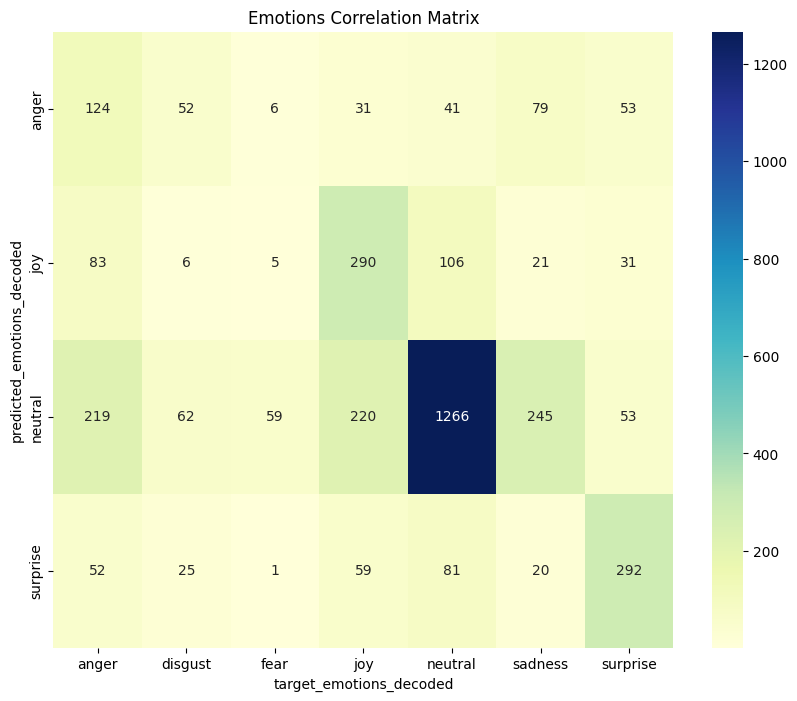

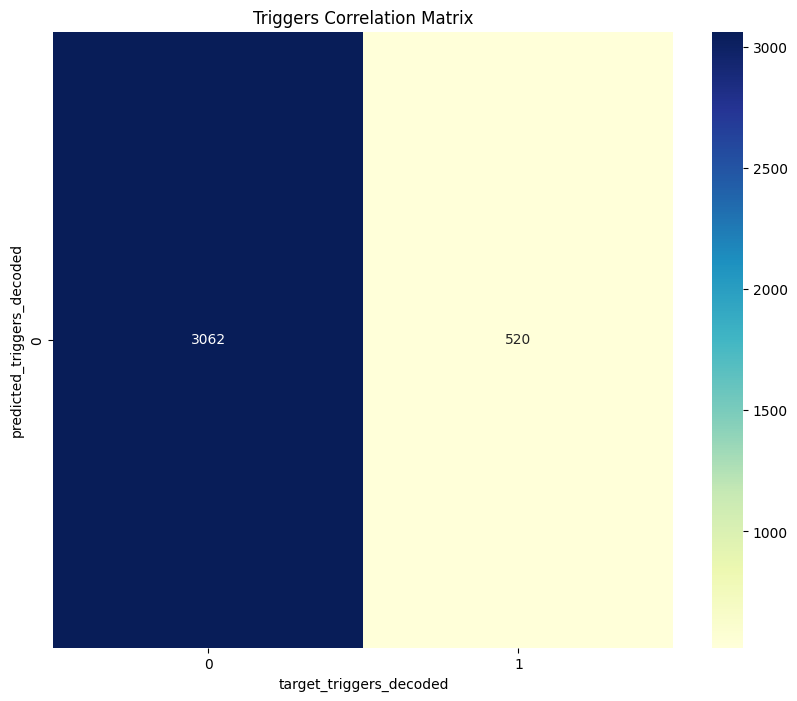

In [67]:
# Decoding the labels
results_df_full = process_dataframe(results_df_full, emotions_encoded_dict, triggers_encoded_dict)

# Generating correlation matrices and classification reports 
emotions_corr_matrix, triggers_corr_matrix, emotions_classification_report, triggers_classification_report = calculate_metrics(results_df_full)

# Plot heatmaps
plot_heatmap(emotions_corr_matrix, "Emotions Correlation Matrix")
plot_heatmap(triggers_corr_matrix, "Triggers Correlation Matrix")

#### Classification reports for full model

In [68]:
# Printing classification reports
print("Emotions Classification Report:\n", emotions_classification_report)
print("Triggers Classification Report:\n", triggers_classification_report)

Emotions Classification Report:
               precision    recall  f1-score   support

       anger       0.32      0.26      0.29       478
     disgust       0.00      0.00      0.00       145
        fear       0.00      0.00      0.00        71
         joy       0.54      0.48      0.51       600
     neutral       0.60      0.85      0.70      1494
     sadness       0.00      0.00      0.00       365
    surprise       0.55      0.68      0.61       429

    accuracy                           0.55      3582
   macro avg       0.29      0.32      0.30      3582
weighted avg       0.45      0.55      0.49      3582

Triggers Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92      3062
           1       0.00      0.00      0.00       520

    accuracy                           0.85      3582
   macro avg       0.43      0.50      0.46      3582
weighted avg       0.73      0.85      0.79      3582



#### Heatmaps for freezed model

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

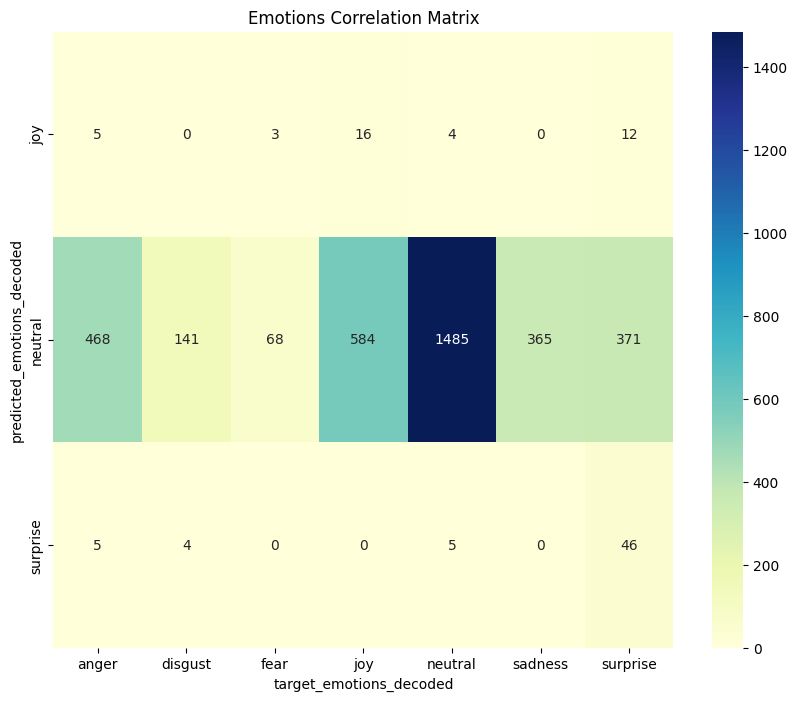

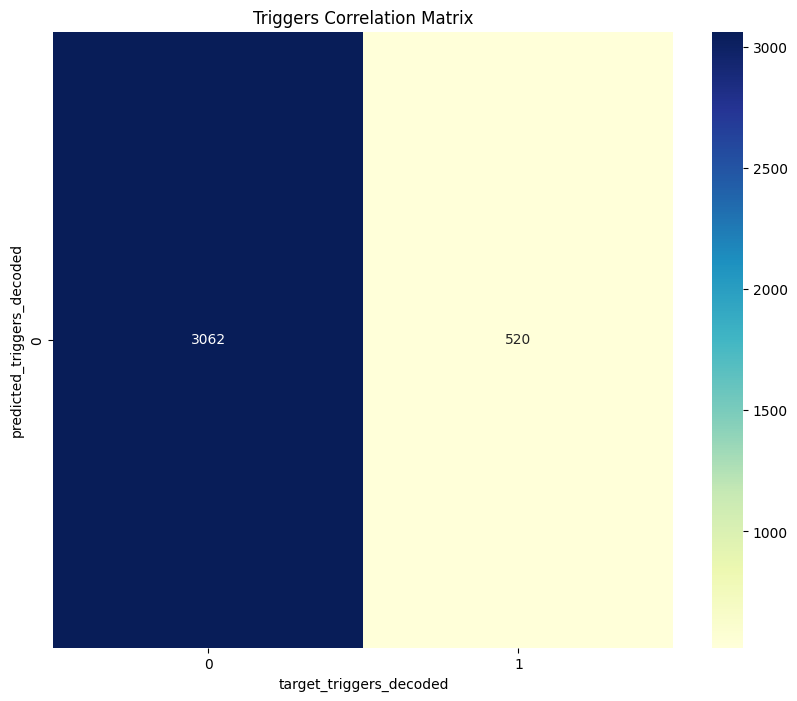

In [69]:
# Decoding the labels
results_df_freezed = process_dataframe(results_df_freezed, emotions_encoded_dict, triggers_encoded_dict)

# Generating correlation matrices and classification reports 
emotions_corr_matrix, triggers_corr_matrix, emotions_classification_report, triggers_classification_report = calculate_metrics(results_df_freezed)

# Plot heatmaps
plot_heatmap(emotions_corr_matrix, "Emotions Correlation Matrix")
plot_heatmap(triggers_corr_matrix, "Triggers Correlation Matrix")

#### Classification reports for freezed model

In [70]:
# Printing classification reports
print("Emotions Classification Report:\n", emotions_classification_report)
print("Triggers Classification Report:\n", triggers_classification_report)

Emotions Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00       478
     disgust       0.00      0.00      0.00       145
        fear       0.00      0.00      0.00        71
         joy       0.40      0.03      0.05       600
     neutral       0.43      0.99      0.60      1494
     sadness       0.00      0.00      0.00       365
    surprise       0.77      0.11      0.19       429

    accuracy                           0.43      3582
   macro avg       0.23      0.16      0.12      3582
weighted avg       0.34      0.43      0.28      3582

Triggers Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92      3062
           1       0.00      0.00      0.00       520

    accuracy                           0.85      3582
   macro avg       0.43      0.50      0.46      3582
weighted avg       0.73      0.85      0.79      3582



### Evaluation Metrics Definition

#### Definition of Average F1 score for the two models: the function computes the F1 score for each row; then, an average is computed over each dialogue; finally, an average over all the dialogues is returned.

In [71]:
def calculate_average_f1_score(df):
    # Calculate F1 score for each row
    df['f1_emotions'] = df.apply(lambda row: f1_score([row['target_emotions_decoded']], [row['predicted_emotions_decoded']], average='weighted'), axis=1)
    df['f1_triggers'] = df.apply(lambda row: f1_score([row['target_triggers_decoded']], [row['predicted_triggers_decoded']], average='weighted'), axis=1)
    
    # Group by 'episode' and calculate average F1 score for each dialogue
    grouped = df.groupby('episode').agg({
        'f1_emotions': 'mean',
        'f1_triggers': 'mean'
    }).reset_index()
    
    # Calculate the overall average F1 score
    average_f1_emotions = grouped['f1_emotions'].mean()
    average_f1_triggers = grouped['f1_triggers'].mean()
    
    return average_f1_emotions, average_f1_triggers

#### Computation of Average F1 score for the two models

In [72]:
# Calculate average f1 score for the two models
average_f1_emotions_full, average_f1_triggers_full = calculate_average_f1_score(results_df_full)
average_f1_emotions_freezed, average_f1_triggers_freezed = calculate_average_f1_score(results_df_freezed)

# Print the obtained scores
print('FULL MODEL:')
print("Average F1 Score for Emotions:", average_f1_emotions_full)
print("Average F1 Score for Triggers:", average_f1_triggers_full)
print('\n')
print('FREEZED MODEL:')
print("Average F1 Score for Emotions:", average_f1_emotions_freezed)
print("Average F1 Score for Triggers:", average_f1_triggers_freezed)

FULL MODEL:
Average F1 Score for Emotions: 0.5677400693190218
Average F1 Score for Triggers: 0.8093200770801751


FREEZED MODEL:
Average F1 Score for Emotions: 0.42978778427026876
Average F1 Score for Triggers: 0.8093200770801751


#### Definition of Unrolled F1 score for the two models: the function computes the F1 score for each row; then, a per-category and a global average are computed over all the rows.

In [75]:
def compute_unrolled_f1_score(df):
    # Calculate F1 score for each row
    df['f1_emotions'] = df.apply(lambda row: f1_score([row['target_emotions_decoded']], [row['predicted_emotions_decoded']], average='weighted'), axis=1)
    df['f1_triggers'] = df.apply(lambda row: f1_score([row['target_triggers_decoded']], [row['predicted_triggers_decoded']], average='weighted'), axis=1)
    
    # Calculate global unrolled F1 score
    global_unrolled_f1_emotions = df['f1_emotions'].mean()
    global_unrolled_f1_triggers = df['f1_triggers'].mean()
    
    # Group by target_emotions_decoded and target_triggers_decoded and calculate average F1 score for each group
    grouped_unrolled_f1_emotions = df.groupby('target_emotions_decoded')['f1_emotions'].mean().reset_index()
    grouped_unrolled_f1_triggers = df.groupby('target_triggers_decoded')['f1_triggers'].mean().reset_index()
    
    return global_unrolled_f1_emotions, global_unrolled_f1_triggers, grouped_unrolled_f1_emotions, grouped_unrolled_f1_triggers

#### Computation of Unrolled F1 score for the two models

In [76]:
# Calculate unrolled F1 score for the two models
global_unrolled_f1_emotions_full, global_unrolled_f1_triggers_full, grouped_unrolled_f1_emotions_full, grouped_unrolled_f1_triggers_full = compute_unrolled_f1_score(results_df_full)
global_unrolled_f1_emotions_freezed, global_unrolled_f1_triggers_freezed, grouped_unrolled_f1_emotions_freezed, grouped_unrolled_f1_triggers_freezed = compute_unrolled_f1_score(results_df_freezed)

# Print the obtained scores
print('FULL MODEL:')
print("Global Unrolled F1 Score for Emotions:", global_unrolled_f1_emotions_full)
print("Global Unrolled F1 Score for Triggers:", global_unrolled_f1_triggers_full)
print('\n')
print("Unrolled F1 Score per Category for Emotions:", grouped_unrolled_f1_emotions_full)
print('\n')
print("Unrolled F1 Score per Category for Triggers:", grouped_unrolled_f1_triggers_full)
print('\n\n')
print('FREEZED MODEL:')
print("Global Unrolled F1 Score for Emotions:", global_unrolled_f1_emotions_freezed)
print("Global Unrolled F1 Score for Triggers:", global_unrolled_f1_triggers_freezed)
print('\n')
print("Unrolled F1 Score per Category for Emotions:", grouped_unrolled_f1_emotions_freezed)
print('\n')
print("Unrolled F1 Score per Category for Triggers:", grouped_unrolled_f1_triggers_freezed)

FULL MODEL:
Global Unrolled F1 Score for Emotions: 0.5505304299274149
Global Unrolled F1 Score for Triggers: 0.8548297040759353


Unrolled F1 Score per Category for Emotions:   target_emotions_decoded  f1_emotions
0                   anger     0.259414
1                 disgust     0.000000
2                    fear     0.000000
3                     joy     0.483333
4                 neutral     0.847390
5                 sadness     0.000000
6                surprise     0.680653


Unrolled F1 Score per Category for Triggers:    target_triggers_decoded  f1_triggers
0                        0          1.0
1                        1          0.0



FREEZED MODEL:
Global Unrolled F1 Score for Emotions: 0.43188163037409266
Global Unrolled F1 Score for Triggers: 0.8548297040759353


Unrolled F1 Score per Category for Emotions:   target_emotions_decoded  f1_emotions
0                   anger     0.000000
1                 disgust     0.000000
2                    fear     0.000000
3       

### Error Analysis

#### We examine some misclassification examples choosen in the classes showing the poorest per-category performances for the two models:

In [77]:
def find_misclassification_examples(df, grouped_unrolled_f1_emotions, grouped_unrolled_f1_triggers):
    # Identify the emotion and target with lowest grouped unrolled F1 score
    poorest_emotion = grouped_unrolled_f1_emotions.loc[grouped_unrolled_f1_emotions['f1_emotions'].idxmin()]['target_emotions_decoded']
    poorest_trigger = grouped_unrolled_f1_triggers.loc[grouped_unrolled_f1_triggers['f1_triggers'].idxmin()]['target_triggers_decoded']
    
    # Find misclassification examples for the poorest performing emotion
    emotion_misclassifications = df[(df['target_emotions_decoded'] == poorest_emotion) & (df['target_emotions_decoded'] != df['predicted_emotions_decoded'])]
    if not emotion_misclassifications.empty:
        emotion_example = emotion_misclassifications.iloc[0]
        emotion_dialogue = original_df[original_df['episode'] == emotion_example['episode']]
        print(f"Emotion Misclassification Example:")
        print(f"Episode: {emotion_example['episode']}")
        print("\n")
        print(emotion_dialogue)
        print("\n")
        print(f"Target Emotion: {emotion_example['target_emotions_decoded']}")
        print(f"Predicted Emotion: {emotion_example['predicted_emotions_decoded']}")
        
    print("---------------------------------------------------------------------------------")
        
    # Find misclassification examples for the poorest performing trigger
    trigger_misclassifications = df[(df['target_triggers_decoded'] == poorest_trigger) & (df['target_triggers_decoded'] != df['predicted_triggers_decoded'])]
    if not trigger_misclassifications.empty:
        trigger_example = trigger_misclassifications.iloc[0]
        trigger_dialogue = original_df[original_df['episode'] == trigger_example['episode']]
        print(f"Trigger Misclassification Example:")
        print(f"Episode: {trigger_example['episode']}")
        print("\n")
        print(trigger_dialogue)
        print("\n")
        print(f"Target Trigger: {trigger_example['target_triggers_decoded']}")
        print(f"Predicted Trigger: {trigger_example['predicted_triggers_decoded']}")
        

In [78]:
# Function to find misclassification examples
def find_misclassifications(df, emotions_encoded_dict, triggers_encoded_dict):
    # Calculate F1 scores
    avg_f1_emotions_per_category, avg_f1_triggers_per_category, _, _ = calculate_unrolled_f1_score(df)
    
    # Identify categories with the poorest performance
    poorest_emotion_category = np.argmin(avg_f1_emotions_per_category)
    poorest_trigger_category = np.argmin(avg_f1_triggers_per_category)
    
    # Decode category indices to labels
    emotion_labels = list(emotions_encoded_dict.keys())
    trigger_labels = list(triggers_encoded_dict.keys())
    
    poorest_emotion_label = emotion_labels[poorest_emotion_category]
    poorest_trigger_label = trigger_labels[poorest_trigger_category]
    
    # Find misclassification examples
    misclassified_emotions = df[(df['target_emotions_decoded'] == poorest_emotion_label) & 
                                (df['predicted_emotions_decoded'] != poorest_emotion_label)]
    
    misclassified_triggers = df[(df['target_triggers_decoded'] == poorest_trigger_label) & 
                                (df['predicted_triggers_decoded'] != poorest_trigger_label)]
    
    return misclassified_emotions, misclassified_triggers


#### Misclassification examples for full model

In [79]:
find_misclassification_examples(results_df_full, grouped_unrolled_f1_emotions_full, grouped_unrolled_f1_triggers_full)

Emotion Misclassification Example:
Episode: utterance_3606


             episode                  speakers                     emotions  \
3606  utterance_3606  [Rachel, Monica, Rachel]  [disgust, sadness, sadness]   

                                             utterances         triggers  
3606  [Oh God, I hate my job, I hate it, I hate my j...  [1.0, 0.0, 1.0]  


Target Emotion: disgust
Predicted Emotion: anger
---------------------------------------------------------------------------------
Trigger Misclassification Example:
Episode: utterance_3603


             episode                                           speakers  \
3603  utterance_3603  [The Conductor, Ross, Woman On Train, Ross, Wo...   

                                               emotions  \
3603  [neutral, surprise, neutral, surprise, neutral...   

                                             utterances  \
3603  [Last stop, Montreal. This stop is Montreal., ...   

                                      triggers 

#### Misclassification examples for freezed model

In [80]:
find_misclassification_examples(results_df_freezed, grouped_unrolled_f1_emotions_freezed, grouped_unrolled_f1_triggers_freezed)

Emotion Misclassification Example:
Episode: utterance_3604


             episode          speakers          emotions  \
3604  utterance_3604  [Monica, Monica]  [neutral, anger]   

                                             utterances    triggers  
3604  [Okay, here's batch 22., Oh, maybe these'll ta...  [0.0, 1.0]  


Target Emotion: anger
Predicted Emotion: neutral
---------------------------------------------------------------------------------
Trigger Misclassification Example:
Episode: utterance_3603


             episode                                           speakers  \
3603  utterance_3603  [The Conductor, Ross, Woman On Train, Ross, Wo...   

                                               emotions  \
3603  [neutral, surprise, neutral, surprise, neutral...   

                                             utterances  \
3603  [Last stop, Montreal. This stop is Montreal., ...   

                                      triggers  
3603  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]

Da fare d'ora in poi:
- sistemare e commentare il codice 
- report